In [ ]:
import os
import json
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Deep_Learning_homework/Data'

/content/drive/My Drive/Deep_Learning_homework/Data


In [ ]:
# Veri yolları
csv_path = "new_train.csv"
json_path = "label_num_to_disease_map.json"
image_folder = "train_images"
# Sınıf adları
with open(json_path, 'r') as f:
    class_names = json.load(f)

In [ ]:
# Veri yollarını yükleyin
df = pd.read_csv(csv_path)

# **Etiket Sayısı hesaplama**

In [ ]:
# Label sütunundaki değerleri say
label_counts = df['label'].value_counts()

# Etiketlerin sayısını yazdır
print("Etiket 0 olanların sayısı:", label_counts.get(0, 0))
print("Etiket 1 olanların sayısı:", label_counts.get(1, 0))
print("Etiket 2 olanların sayısı:", label_counts.get(2, 0))
print("Etiket 3 olanların sayısı:", label_counts.get(3, 0))
print("Etiket 4 olanların sayısı:", label_counts.get(4, 0))

Etiket 0 olanların sayısı: 1087
Etiket 1 olanların sayısı: 2189
Etiket 2 olanların sayısı: 2386
Etiket 3 olanların sayısı: 13158
Etiket 4 olanların sayısı: 2577


In [ ]:
# Her sınıf için resim ve labellı resim sayılarını hesapla
class_counts = {}
for label, class_name in class_names.items():
    class_images = len(df[df['label'] == int(label)])
    labeled_images = class_images
    class_counts[class_name] = {'images': class_images, 'labeled_images': labeled_images}

    print(f"Sınıf: {class_name}, Toplam Resim Sayısı: {class_images}, Etiketli Resim Sayısı: {labeled_images}")

Sınıf: Cassava Bacterial Blight (CBB), Toplam Resim Sayısı: 1087, Etiketli Resim Sayısı: 1087
Sınıf: Cassava Brown Streak Disease (CBSD), Toplam Resim Sayısı: 2189, Etiketli Resim Sayısı: 2189
Sınıf: Cassava Green Mottle (CGM), Toplam Resim Sayısı: 2386, Etiketli Resim Sayısı: 2386
Sınıf: Cassava Mosaic Disease (CMD), Toplam Resim Sayısı: 13158, Etiketli Resim Sayısı: 13158
Sınıf: Healthy, Toplam Resim Sayısı: 2577, Etiketli Resim Sayısı: 2577


In [ ]:
import os

# train.csv dosyasının boyutunu yazdır
csv_size = os.path.getsize(csv_path)
print(f"train.csv dosyasının boyutu: {csv_size} bytes")

# image_folder içindeki resim sayısını hesapla
image_files = os.listdir(image_folder)
num_images = len(image_files)
print(f"{image_folder} klasöründe {num_images} resim bulunmaktadır.")


train.csv dosyasının boyutu: 379681 bytes
train_images klasöründe 17938 resim bulunmaktadır.


In [ ]:
import os

image_folder = "train_images"
image_id = "1000015157.jpg"

img_path = os.path.join(image_folder, image_id)

if os.path.exists(img_path):
    print(f"{image_id} dosyası {image_folder} klasöründe bulunuyor.")
else:
    print(f"{image_id} dosyası {image_folder} klasöründe bulunmuyor.")


1000015157.jpg dosyası train_images klasöründe bulunmuyor.


In [ ]:
import pandas as pd

csv_path = "train.csv"
image_id_to_check = "1000015157.jpg"

# CSV dosyasını oku
df = pd.read_csv(csv_path)

# image_id sütununda belirtilen dosyanın olup olmadığını kontrol et
if image_id_to_check in df['image_id'].values:
    print(f"{image_id_to_check} dosyası train.csv dosyasında bulunuyor.")
else:
    print(f"{image_id_to_check} dosyası train.csv dosyasında bulunmuyor.")


1000015157.jpg dosyası train.csv dosyasında bulunuyor.


In [ ]:
import pandas as pd
import os

# Boş bir DataFrame oluştur
new_df = pd.DataFrame(columns=['image_id', 'label'])

df = pd.read_csv(csv_path)


for image_id, label in zip(df['image_id'], df['label']):
    img_path = os.path.join(image_folder, image_id)

    # Eğer dosya mevcutsa işleme devam et, aksi takdirde atla
    if os.path.exists(img_path):
        # Yeni bir satır oluştur
        new_row = pd.DataFrame({'image_id': [image_id], 'label': [label]})
        # Mevcut DataFrame'e yeni satırı ekle
        new_df = pd.concat([new_df, new_row], ignore_index=True)
# Sonuçları göster
print(new_df)


             image_id label
0       157078263.jpg     3
1      1574893536.jpg     3
2      1575013487.jpg     3
3      1576606254.jpg     0
4      1579761476.jpg     1
...               ...   ...
17933   999068805.jpg     3
17934   999329392.jpg     3
17935   999474432.jpg     1
17936   999616605.jpg     4
17937   999998473.jpg     4

[17938 rows x 2 columns]


In [ ]:
df.shape[0]

21397

In [ ]:
new_df.to_csv('new_train.csv', index=False)

# **Veri dengesizliği**

In [ ]:
import pandas as pd
from sklearn.utils import resample

In [ ]:
# Etiketlere göre veri setini bölün
df_class_0 = df[df['label'] == 0]
df_class_3 = df[df['label'] == 3]

# Diğer sınıfları ayırın
df_others = df[(df['label'] != 0) & (df['label'] != 3)]


In [ ]:
# 0 etiketli sınıfı 2000 örneğe ayarlayın
if len(df_class_0) < 2000:
    df_class_0_resampled = resample(df_class_0, replace=True, n_samples=2000, random_state=123)
else:
    df_class_0_resampled = resample(df_class_0, replace=False, n_samples=2000, random_state=123)

# 3 etiketli sınıfı 2000 örneğe ayarlayın
if len(df_class_3) < 2000:
    df_class_3_resampled = resample(df_class_3, replace=True, n_samples=2000, random_state=123)
else:
    df_class_3_resampled = resample(df_class_3, replace=False, n_samples=2000, random_state=123)


In [ ]:
# Yeniden örneklenmiş veri setlerini birleştirin
df_resampled = pd.concat([df_class_0_resampled, df_class_3_resampled, df_others])

# Karışık hale getirmek için verileri karıştırın
df_resampled = df_resampled.sample(frac=1, random_state=123).reset_index(drop=True)

# Sonuçları kontrol edin
print(df_resampled['label'].value_counts())


label
4    2166
0    2000
3    2000
2    1993
1    1831
Name: count, dtype: int64


# **Preprocessing**

In [ ]:

# Data and Labels Collection
data = []
labels = []
success_count = 0
skip_count = 0
input_shape=(224, 224)

df = pd.read_csv("new_train.csv")

for image_id, label in zip(df['image_id'], df['label']):
    img_path = os.path.join(image_folder, image_id)

    # Eğer dosya mevcutsa işleme devam et, aksi takdirde atla
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        resized_img = cv2.resize(img, (224, 224))
        data.append(resized_img)
        labels.append(label)
        success_count += 1
    else:
        print(f"Uyarı: {img_path} bulunamadı, bu nedenle atlandı.")
        skip_count += 1

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Başarılı işlenen fotoğraf sayısı: {success_count}")
print(f"Atlanan fotoğraf sayısı: {skip_count}")

KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import cv2


# Veri ve etiket listelerini başlat
data = []
labels = []
success_count = 0
skip_count = 0

def process_image(image_id, label):
    img_path = os.path.join(image_folder, image_id)

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, (224, 224))
            return (resized_img, label, True)
    return (None, label, False)

# Paralel işleme için ThreadPoolExecutor kullan
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, image_id, label) for image_id, label in zip(df_resampled['image_id'], df_resampled['label'])]

    for future in as_completed(futures):
        result, label, success = future.result()
        if success:
            data.append(result)
            labels.append(label)
            success_count += 1
        else:
            skip_count += 1

# İşlemler tamamlandıktan sonra sonuçları yazdır
print(f"Başarıyla eklenen resim sayısı: {success_count}")
print(f"Atlanan resim sayısı: {skip_count}")

Başarıyla eklenen resim sayısı: 9990
Atlanan resim sayısı: 0


In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

num_classes = len(class_names)

# Convert training labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)

# Convert testing labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes)

# **Model Oluşturma**

In [ ]:
def build_inceptionv3_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of base model
    for layer in base_model.layers:
        layer.trainable = True

    return model

# Örnek kullanım
input_shape = (224, 224, 3)
model = build_inceptionv3_model(input_shape, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

# **Model Eğitimi**

In [ ]:

# Compile Model
model.compile(optimizer= Adam(0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("best_googlenet_model_weights.h5",
                             monitor='val_acc',  # Kaydetme kriteri olarak doğruluk metriğini kullanın
                             verbose=1,
                             save_best_only=True,    # Sadece en iyi performansı gösteren ağırlıkları kaydedin
                             mode='max')
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto', factor=0.1, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
# Modeli eğit
history=model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_split=0.2, verbose=1,callbacks=[reduce_lr,checkpoint,early_stopping])

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 2.0773 - accuracy: 0.2134

200/200 [==============================] - 98s 285ms/step - loss: 2.0773 - accuracy: 0.2134 - val_loss: 7.0215 - val_accuracy: 0.2333 - lr: 0.0100
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 1.6049 - accuracy: 0.2115

200/200 [==============================] - 50s 250ms/step - loss: 1.6049 - accuracy: 0.2115 - val_loss: 1.6249 - val_accuracy: 0.2258 - lr: 0.0100
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.2296

200/200 [==============================] - 50s 251ms/step - loss: 1.5868 - accuracy: 0.2296 - val_loss: 1.6190 - val_accuracy: 0.2026 - lr: 0.0100
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 1.5461 - accuracy: 0.2723

200/200 [==============================] - 48s 240ms/step - loss: 1.5461 - accuracy: 0.2723 - val_loss: 6.4470 - val_accuracy: 0.2314 - lr: 0.0100
Epoch 5/100
200/200 [==============================] - ETA: 0s - loss: 1.4567 - accuracy: 0.3338

200/200 [==============================] - 50s 251ms/step - loss: 1.4567 - accuracy: 0.3338 - val_loss: 1.7948 - val_accuracy: 0.3321 - lr: 0.0100
Epoch 6/100
200/200 [==============================] - ETA: 0s - loss: 1.3821 - accuracy: 0.3931

200/200 [==============================] - 48s 240ms/step - loss: 1.3821 - accuracy: 0.3931 - val_loss: 1.8421 - val_accuracy: 0.2470 - lr: 0.0100
Epoch 7/100
200/200 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.4059

200/200 [==============================] - 50s 251ms/step - loss: 1.3507 - accuracy: 0.4059 - val_loss: 1.4160 - val_accuracy: 0.3727 - lr: 0.0100
Epoch 8/100
200/200 [==============================] - ETA: 0s - loss: 1.3166 - accuracy: 0.4300

200/200 [==============================] - 48s 240ms/step - loss: 1.3166 - accuracy: 0.4300 - val_loss: 1.5761 - val_accuracy: 0.3521 - lr: 0.0100
Epoch 9/100
200/200 [==============================] - ETA: 0s - loss: 1.2945 - accuracy: 0.4402

200/200 [==============================] - 50s 251ms/step - loss: 1.2945 - accuracy: 0.4402 - val_loss: 1.7966 - val_accuracy: 0.3609 - lr: 0.0100
Epoch 10/100
200/200 [==============================] - ETA: 0s - loss: 1.2643 - accuracy: 0.4647

200/200 [==============================] - 50s 250ms/step - loss: 1.2643 - accuracy: 0.4647 - val_loss: 2.0029 - val_accuracy: 0.2433 - lr: 0.0100
Epoch 11/100
200/200 [==============================] - ETA: 0s - loss: 1.2155 - accuracy: 0.4890

200/200 [==============================] - 50s 250ms/step - loss: 1.2155 - accuracy: 0.4890 - val_loss: 1.9139 - val_accuracy: 0.2846 - lr: 0.0100
Epoch 12/100
200/200 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.5134

200/200 [==============================] - 50s 251ms/step - loss: 1.1772 - accuracy: 0.5134 - val_loss: 1.3941 - val_accuracy: 0.4146 - lr: 0.0100
Epoch 13/100
200/200 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.5544

200/200 [==============================] - 48s 241ms/step - loss: 1.1235 - accuracy: 0.5544 - val_loss: 1.1580 - val_accuracy: 0.5285 - lr: 0.0100
Epoch 14/100
200/200 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.4999

200/200 [==============================] - 48s 240ms/step - loss: 1.2258 - accuracy: 0.4999 - val_loss: 1.6781 - val_accuracy: 0.2233 - lr: 0.0100
Epoch 15/100
200/200 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.4744

200/200 [==============================] - 48s 240ms/step - loss: 1.2621 - accuracy: 0.4744 - val_loss: 1.8486 - val_accuracy: 0.2770 - lr: 0.0100
Epoch 16/100
200/200 [==============================] - ETA: 0s - loss: 1.1368 - accuracy: 0.5393

200/200 [==============================] - 48s 240ms/step - loss: 1.1368 - accuracy: 0.5393 - val_loss: 1.3895 - val_accuracy: 0.3946 - lr: 0.0100
Epoch 17/100
200/200 [==============================] - ETA: 0s - loss: 1.1113 - accuracy: 0.5531

200/200 [==============================] - 50s 250ms/step - loss: 1.1113 - accuracy: 0.5531 - val_loss: 6.2263 - val_accuracy: 0.1939 - lr: 0.0100
Epoch 18/100
200/200 [==============================] - ETA: 0s - loss: 1.0760 - accuracy: 0.5709

200/200 [==============================] - 50s 251ms/step - loss: 1.0760 - accuracy: 0.5709 - val_loss: 1.0874 - val_accuracy: 0.5604 - lr: 0.0100
Epoch 19/100
200/200 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.5736

200/200 [==============================] - 50s 250ms/step - loss: 1.0539 - accuracy: 0.5736 - val_loss: 2.1114 - val_accuracy: 0.2470 - lr: 0.0100
Epoch 20/100
200/200 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.4103

200/200 [==============================] - 50s 249ms/step - loss: 1.3393 - accuracy: 0.4103 - val_loss: 1.8091 - val_accuracy: 0.2276 - lr: 0.0100
Epoch 21/100
200/200 [==============================] - ETA: 0s - loss: 1.3340 - accuracy: 0.4327

200/200 [==============================] - 50s 250ms/step - loss: 1.3340 - accuracy: 0.4327 - val_loss: 6.9532 - val_accuracy: 0.3315 - lr: 0.0100
Epoch 22/100
200/200 [==============================] - ETA: 0s - loss: 1.2425 - accuracy: 0.4802

200/200 [==============================] - 50s 251ms/step - loss: 1.2425 - accuracy: 0.4802 - val_loss: 2.1191 - val_accuracy: 0.2714 - lr: 0.0100
Epoch 23/100
200/200 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.5354

200/200 [==============================] - 50s 250ms/step - loss: 1.1495 - accuracy: 0.5354 - val_loss: 1.4474 - val_accuracy: 0.3952 - lr: 0.0100
Epoch 24/100
200/200 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.5764

200/200 [==============================] - 52s 258ms/step - loss: 1.0570 - accuracy: 0.5764 - val_loss: 1.2153 - val_accuracy: 0.5103 - lr: 1.0000e-03
Epoch 25/100
200/200 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.5921

200/200 [==============================] - 50s 250ms/step - loss: 1.0233 - accuracy: 0.5921 - val_loss: 1.0470 - val_accuracy: 0.5816 - lr: 1.0000e-03
Epoch 26/100
200/200 [==============================] - ETA: 0s - loss: 0.9981 - accuracy: 0.6028

200/200 [==============================] - 48s 240ms/step - loss: 0.9981 - accuracy: 0.6028 - val_loss: 1.0762 - val_accuracy: 0.5872 - lr: 1.0000e-03
Epoch 27/100
200/200 [==============================] - ETA: 0s - loss: 0.9691 - accuracy: 0.6183

200/200 [==============================] - 48s 242ms/step - loss: 0.9691 - accuracy: 0.6183 - val_loss: 1.0017 - val_accuracy: 0.6054 - lr: 1.0000e-03
Epoch 28/100
200/200 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.6213

200/200 [==============================] - 48s 240ms/step - loss: 0.9611 - accuracy: 0.6213 - val_loss: 1.0508 - val_accuracy: 0.5785 - lr: 1.0000e-03
Epoch 29/100
200/200 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.6307

200/200 [==============================] - 48s 239ms/step - loss: 0.9437 - accuracy: 0.6307 - val_loss: 1.1854 - val_accuracy: 0.6016 - lr: 1.0000e-03
Epoch 30/100
200/200 [==============================] - ETA: 0s - loss: 0.9363 - accuracy: 0.6291

200/200 [==============================] - 48s 241ms/step - loss: 0.9363 - accuracy: 0.6291 - val_loss: 0.9952 - val_accuracy: 0.6060 - lr: 1.0000e-03
Epoch 31/100
200/200 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.6527

200/200 [==============================] - 48s 240ms/step - loss: 0.8952 - accuracy: 0.6527 - val_loss: 0.9937 - val_accuracy: 0.6016 - lr: 1.0000e-03
Epoch 32/100
200/200 [==============================] - ETA: 0s - loss: 0.8659 - accuracy: 0.6631

200/200 [==============================] - 49s 247ms/step - loss: 0.8659 - accuracy: 0.6631 - val_loss: 1.0480 - val_accuracy: 0.5872 - lr: 1.0000e-03
Epoch 33/100
200/200 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.6720

200/200 [==============================] - 48s 240ms/step - loss: 0.8399 - accuracy: 0.6720 - val_loss: 1.1062 - val_accuracy: 0.5910 - lr: 1.0000e-03
Epoch 34/100
200/200 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.6953

200/200 [==============================] - 50s 250ms/step - loss: 0.7908 - accuracy: 0.6953 - val_loss: 1.1720 - val_accuracy: 0.6041 - lr: 1.0000e-03
Epoch 35/100
200/200 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.7098

200/200 [==============================] - 50s 251ms/step - loss: 0.7531 - accuracy: 0.7098 - val_loss: 0.9907 - val_accuracy: 0.6492 - lr: 1.0000e-03
Epoch 36/100
200/200 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.7188

200/200 [==============================] - 49s 245ms/step - loss: 0.7333 - accuracy: 0.7188 - val_loss: 1.0132 - val_accuracy: 0.6323 - lr: 1.0000e-03
Epoch 37/100
200/200 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.7491

200/200 [==============================] - 48s 240ms/step - loss: 0.6734 - accuracy: 0.7491 - val_loss: 1.4987 - val_accuracy: 0.6223 - lr: 1.0000e-03
Epoch 38/100
200/200 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7672

200/200 [==============================] - 50s 250ms/step - loss: 0.6229 - accuracy: 0.7672 - val_loss: 1.6841 - val_accuracy: 0.6079 - lr: 1.0000e-03
Epoch 39/100
200/200 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.7866

200/200 [==============================] - 50s 250ms/step - loss: 0.5656 - accuracy: 0.7866 - val_loss: 1.2419 - val_accuracy: 0.6435 - lr: 1.0000e-03
Epoch 40/100
200/200 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8099

200/200 [==============================] - 50s 250ms/step - loss: 0.5057 - accuracy: 0.8099 - val_loss: 1.2529 - val_accuracy: 0.6148 - lr: 1.0000e-03
Epoch 41/100
200/200 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8505

200/200 [==============================] - 50s 250ms/step - loss: 0.4085 - accuracy: 0.8505 - val_loss: 1.1532 - val_accuracy: 0.6479 - lr: 1.0000e-04
Epoch 42/100
200/200 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8735

200/200 [==============================] - 50s 252ms/step - loss: 0.3618 - accuracy: 0.8735 - val_loss: 1.1795 - val_accuracy: 0.6485 - lr: 1.0000e-04
Epoch 43/100
200/200 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8868

200/200 [==============================] - 49s 246ms/step - loss: 0.3250 - accuracy: 0.8868 - val_loss: 1.2629 - val_accuracy: 0.6467 - lr: 1.0000e-04


In [ ]:
# Model Evaluation
evaluation = model.evaluate(X_test, y_test_one_hot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)


63/63 [==============================] - 4s 65ms/step - loss: 0.9895 - accuracy: 0.6381
Test accuracy: 0.6381381154060364


In [ ]:

model.save_weights('/content/drive/My Drive/Deep_Learning_homework/Data/model_weights.h5')



63/63 [==============================] - 5s 62ms/step


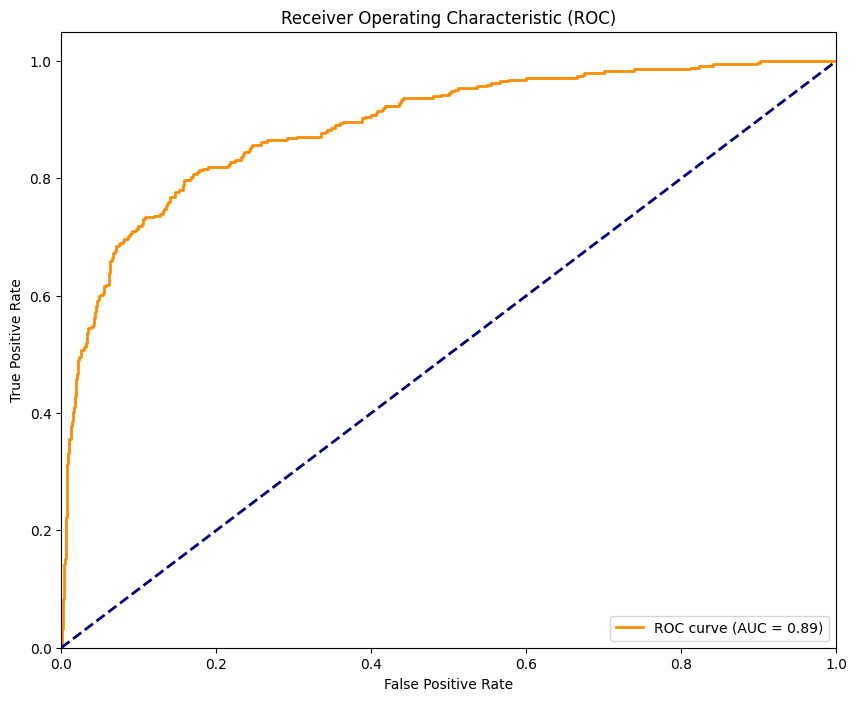

In [ ]:

# Tahminleri yap
predicted_probabilities = model.predict(X_test)

# Tahmin edilen olasılıklardan sadece pozitif sınıfın olasılıklarını seç
predicted_positive_probabilities = predicted_probabilities[:, 1]

# FPR, TPR ve eşik değerlerini hesapla
fpr, tpr, thresholds = roc_curve(y_test_one_hot[:, 1], predicted_positive_probabilities)

# ROC eğrisi altında alanı hesapla
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_one_hot, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

63/63 [==============================] - 4s 62ms/step
Confusion Matrix:
[[291  40   2   3  82]
 [ 27 240  12  35  35]
 [  8  26 178  52 120]
 [  1  39  47 288  20]
 [ 55  38  65  16 278]]


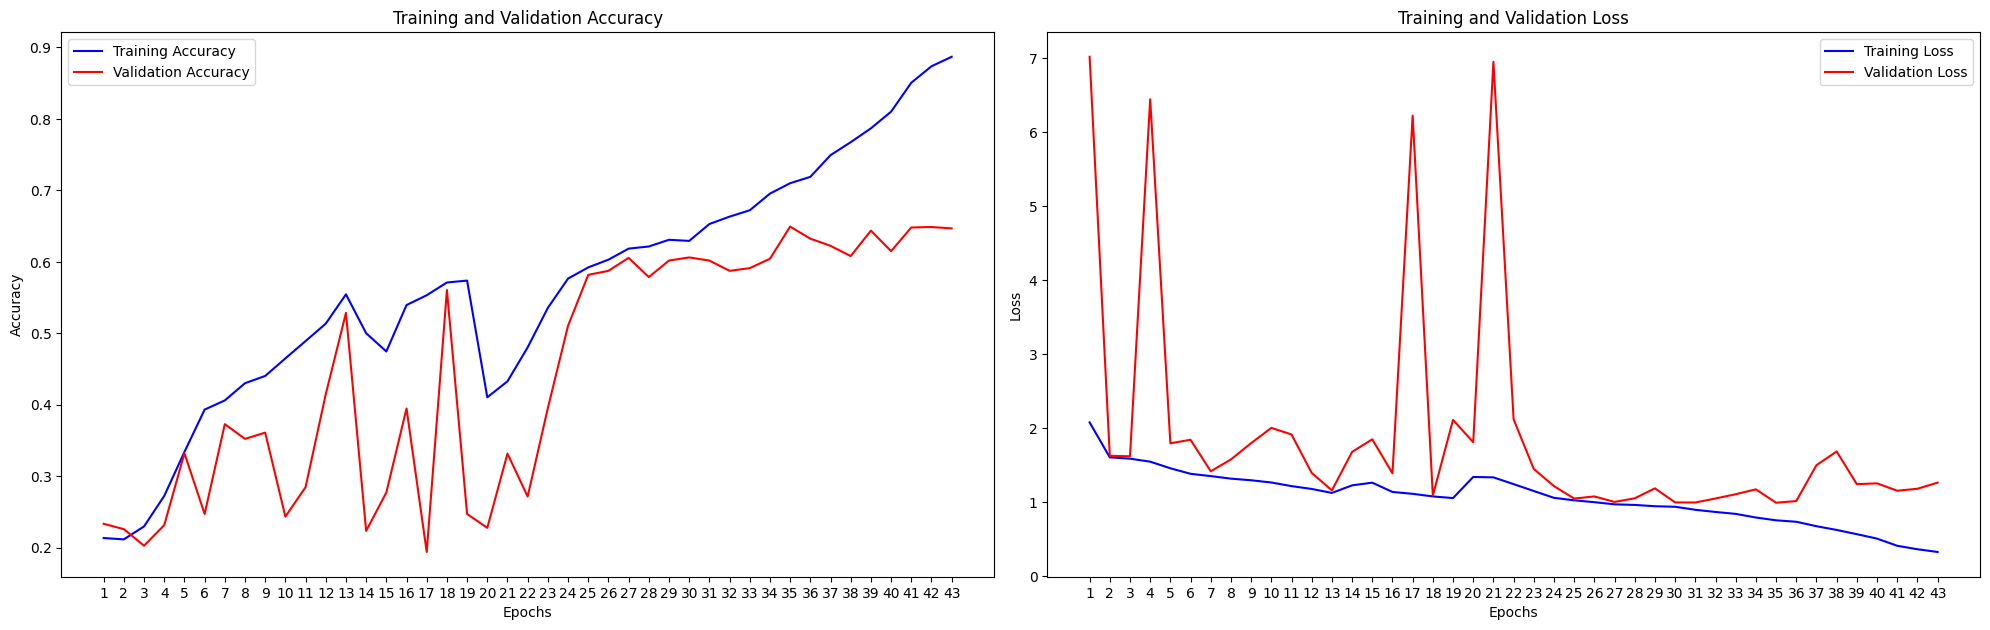

In [ ]:
# Grafik boyutunu ayarlayın
plt.figure(figsize=(20, 12))
# Extracting training history

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(y_test_one_hot, axis=1)

class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)


63/63 [==============================] - 4s 62ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       418
           1       0.63      0.69      0.66       349
           2       0.59      0.46      0.52       384
           3       0.73      0.73      0.73       395
           4       0.52      0.62      0.56       452

    accuracy                           0.64      1998
   macro avg       0.64      0.64      0.64      1998
weighted avg       0.64      0.64      0.64      1998



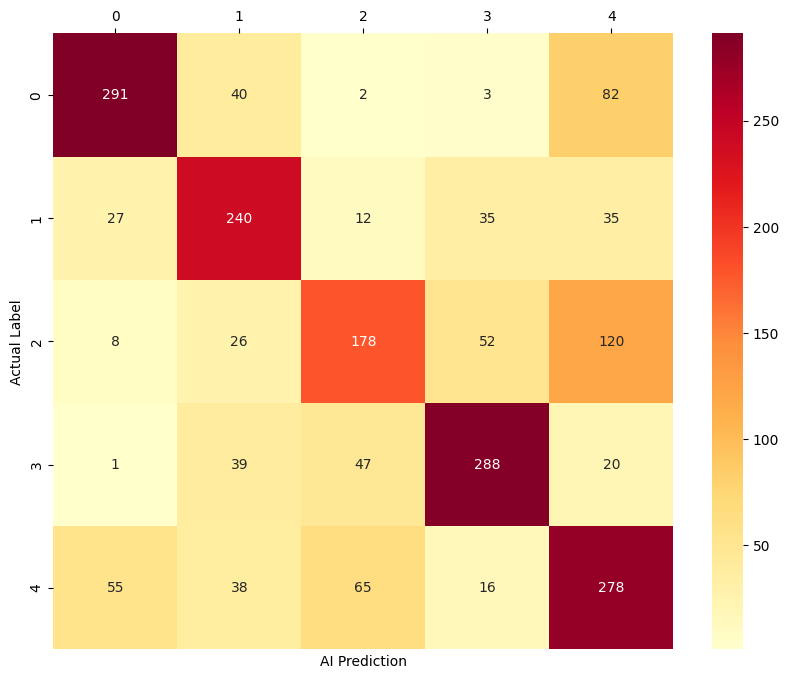

In [ ]:
# Karışıklık matrisini görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=class_names, yticklabels=class_names)
hm.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.show()